# Correlation between restaurants and socioeconomic factors in Lelystad

## Table of Contents
+ [Introduction](#Introduction)
+ [Abstract](#Abstract)
+ [Data to be used](#Data-to-be-used)
+ [Data collection](#Data-collection)
    - [Boroughs of Lelystad](#Boroughs-of-Lelystad)
    - [Socioeconomic data of Lelystad](#Socioeconomic-data-of-Lelystad)
    - [Restaurants in Lelystad](#Restaurants-in-Lelystad)
+ [Visualizing our data](#Visualizing-our-data)
    - [Map of restaurants](#Map-of-restaurant)
    - [Restaurant categories](#Restaurant-categories)
+ [Clustering our data into boroughs](#Clustering-our-data-into-boroughs)
+ [Visualizing clustered restaurants](#Visualizing-clustered-restaurants)
    - [Boroughs with restaurants](#Boroughs-with-restaurants)
    - [Boroughs without restaurants](#Boroughs-without-restaurants)
+ [Finding correlation](#Finding-correlation)
    - [Correlation in words](#Correlation-in-words)
+ [Finding opportunities](#Finding-opportunities)
+ [Conclusion](#Conclusion)

## Introduction
Lelystad is the capital of the Dutch province Flevoland, which is said to be one of the most multicultural diverse provinces of The Netherlands. Lelystad was initially designed around its boroughs, which means that most boroughs have their own shopping center and restaurants. 

I have been fascinated with the restaurant business in Lelystad since my work at EetSmakelijk.nl. When I worked there, we were always looking to extend our reach. We also tried to understand why some restaurants did well in particular boroughs, while others did not. In this research, I will not focus on restaurant rating or popularity, since these are subjective and require surveying a large sample of citizens.

I will however, see if there is a correlation between the amount of restaurants in a certain borough and the demography of the boroughs - as well as finding the socioeconomic factors that seem to correlate most with the amount of restaurants that are located in a borough.

Finally, I will be presenting a list of boroughs where there are opportunities to start a restaurant based on my previous statistical analysis. If you were looking to open a restaurant in Lelystad: this might be the time.

## Abstract
Restaurants are seemingly everywhere, but are they really? In this paper I find, using correlation and location-based clustering, that four socioeconomic factors show a strong correlation with the amount of restaurants in a borough in Lelystad, a fast growing, multiculturally diverse city in The Netherlands. These are:
- The amount of people in a borough that have two parents who were born in The Netherlands
- The percentage of bought houses in a borough, and inversely, the percentage of rented houses in a borough
- The scale of addresses per square meter (expressed on a scale of 1 - low to 5 - high)

Overall I conclude that in Lelystad there is a certain correlation between socioeconomic factors and the amount of restaurants in a borough.

## Data to be used
In order to find a relationship between demographic, socioeconomic variables and the type of and amount of restaurants in a borough, we will need the following data, collected from external resources:
- **Boroughs in Lelystad**, retrieved from [https://www.metatopos.eu/flevoland2.html](https://www.metatopos.eu/flevoland2.html).
- **Socioeconomic data**, collected by the Central Bureau for Statistics in The Netherlands, retrieved as a .csv-file from [https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode).
- **Restaurants in Lelystad**, retrieved from the FourSquare API.

## Data collection

In [173]:
%%capture
# Remove this capture statement to debug pip installation
!pip install pandas
!pip install numpy
!pip install folium
!pip install bs4
!pip install simpledbf
!pip install SQLalchemy
!pip install matplotlib
# !pip install nbconvert
# !pip install pyppeteer

In [174]:
import pandas as pd
import numpy as np
import folium
from bs4 import BeautifulSoup
import requests
import re
from simpledbf import Dbf5
import json
import matplotlib.pyplot as plt
from math import sin, cos, asin, sqrt

### Boroughs of Lelystad

In [175]:
flevoland_borough_web_data = requests.get('https://www.metatopos.eu/flevoland2.html').content
flevoland_borough_soup = BeautifulSoup(flevoland_borough_web_data, 'html.parser')

lelystad_boroughs = pd.DataFrame(columns=['postal_code', 'borough', 'lat', 'lng'])
for index, row in enumerate(flevoland_borough_soup.find('table').find_all('tr')):
    if index == 0:
        # This is the table head, so let's not use it
        pass
    else:
        borough = {}
        cols = row.find_all('td')
        
        if cols[1].text == 'Lelystad':
            postal_code = cols[3].text
            borough = cols[4].text
            lat = re.search('@(.*?),', str(cols[3])).group(0)[1:][:-1]
            lng = re.search(',(.*?),', str(cols[3])).group(0)[1:][:-1]
            borough = {'postal_code': postal_code, 'borough': borough, 'lat': lat, 'lng': lng}
            lelystad_boroughs = lelystad_boroughs.append(borough, ignore_index=True)

# Since we need to merge this later, we should cast the key for merge to an integer
lelystad_boroughs['postal_code'] = lelystad_boroughs['postal_code'].astype(int)
lelystad_boroughs['lat'] = lelystad_boroughs['lat'].astype(float)
lelystad_boroughs['lng'] = lelystad_boroughs['lng'].astype(float)

lelystad_boroughs

,postal_code,borough,lat,lng
0,8211,industrieterrein Oostervaart,52.538798,5.501941
1,8212,"Wijngaard, Bongerd, Oostrandpark, Buitenplaats",52.514697,5.492923
2,8218,bedrijvenpark Larserpoort + ten zuiden van Lar...,52.440146,5.353604
3,8219,"Edelhertweg, Runderweg, Dronterweg, Swifterrin...",52.515177,5.481707
4,8221,"IJsselmeerdijk, Karperweg",52.569803,5.478124
5,8222,"Biologisch Centrum; Groene Velden, Hazeleger, ...",52.538687,5.483483
6,8223,Gildenhof,52.523348,5.481777
7,8224,"Lelycentre, Damrif, Kustrif",52.512792,5.477765
8,8225,"Archipel, Wold, Horst, Kamp, Griend, Zoom",52.502910,5.486276
9,8226,"Sont, Larserdreef",52.490578,5.487027


### Socioeconomic data of Lelystad
The terms of the columns in this file are Dutch, because they have been provided by the Dutch Bureau of Statistics. I will try to comment usage of these columns as much as possible throughout the code. For more information, I highly recommend you read [this piece of information](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/postcode/statistische-gegevens-per-vierkant-en-postcode-peiljaar-2015-en-2016.pdf) provided by the CBS. Optionally, you could use a tool like Google Translate to translate the text.

In [176]:
dbf = Dbf5('./socioeconomic_data.dbf')
netherlands_socioeconomic = dbf.to_dataframe()
netherlands_socioeconomic.rename({'PC4': 'postal_code'}, axis=1, inplace=True)
lelystad_socioeconomic = lelystad_boroughs.merge(netherlands_socioeconomic)

# Remove values that are marked secret by CBS (-99997), as well as data we don't need here.
# Also remove other data that is irrelevant for the socioeconomic data
# We remove WON_4564 (Houses built between 1945 and 1964) because the first houses in Lelystad were built in 1965.
lelystad_socioeconomic.replace(-99997, np.nan, inplace=True)
lelystad_socioeconomic.drop(columns=['borough', 'lat', 'lng', 'WON_4564'], inplace=True)

lelystad_socioeconomic

,postal_code,INWONER,MAN,VROUW,INW_014,INW_1524,INW_2544,INW_4564,INW_65PL,P_NL_ACHTG,...,WON_1524,WON_MRGEZ,P_KOOPWON,P_HUURWON,WON_HCORP,WON_NBEW,WOZWONING,UITKMINAOW,OAD,STED
0,8211,285.0,145.0,140.0,35.0,40.0,45.0,95.0,70.0,80.0,...,15.0,30.0,80.0,20.0,NaN,20.0,385.0,10.0,124,5
1,8212,4550.0,2270.0,2280.0,715.0,465.0,990.0,1225.0,1150.0,80.0,...,NaN,90.0,90.0,10.0,150.0,45.0,222.0,280.0,956,4
2,8218,225.0,125.0,95.0,55.0,35.0,50.0,65.0,20.0,90.0,...,NaN,NaN,70.0,30.0,NaN,5.0,NaN,5.0,18,5
3,8219,2925.0,1510.0,1410.0,615.0,450.0,645.0,955.0,255.0,80.0,...,135.0,10.0,90.0,10.0,NaN,30.0,391.0,110.0,292,5
4,8221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,40,5
5,8222,185.0,90.0,90.0,20.0,15.0,15.0,65.0,70.0,80.0,...,NaN,NaN,100.0,NaN,NaN,NaN,581.0,10.0,336,5
6,8223,4940.0,2550.0,2390.0,995.0,675.0,1335.0,1255.0,675.0,50.0,...,25.0,665.0,50.0,50.0,850.0,80.0,151.0,730.0,1189,3
7,8224,7135.0,3535.0,3595.0,1265.0,805.0,1795.0,1705.0,1570.0,50.0,...,85.0,930.0,50.0,50.0,1265.0,70.0,165.0,875.0,1973,2
8,8225,8100.0,4110.0,3990.0,1390.0,965.0,2360.0,2085.0,1300.0,60.0,...,NaN,475.0,60.0,40.0,1245.0,65.0,170.0,950.0,1993,2
9,8226,9630.0,4850.0,4780.0,1940.0,1315.0,2535.0,2740.0,1100.0,60.0,...,NaN,585.0,60.0,40.0,1335.0,80.0,205.0,1050.0,1486,3


### Restaurants in Lelystad
We can retrieve a list of all restaurants that can be found in Lelystad using the Foursquare API.

In [177]:
# Replace this with your own user and secret token
foursquare_api_user = 'MYRAWBC204ODSPK012UUUTKDZVL35YVFLPIBC11LFM5WQGGR'
foursquare_api_secret = 'JHW5AMMFRHXEQSM1H2C5ULPDR30S1DMUKHQSDBOD1GEBYRIF'
foursquare_base_url = f'https://api.foursquare.com/v2/venues/search?client_id={foursquare_api_user}&client_secret={foursquare_api_secret}&v=20210725&categoryId=4d4b7105d754a06374d81259&limit=50'

restaurants_lelystad = pd.DataFrame(columns=['name', 'category', 'lat', 'lng', 'borough'])

for _, entry in lelystad_boroughs.iterrows():
    foursquare_data = requests.get(f'{foursquare_base_url}&ll={entry["lat"]},{entry["lng"]}&radius=7000').text
    foursquare_data = json.loads(foursquare_data)
    venues = foursquare_data['response']['venues']
    for venue in venues:
        try:
            if venue['location']['city'].lower() == 'lelystad':
                category = None
                for cat in venue['categories']:
                    if cat['primary'] is True:
                        category = cat['name']

                restaurants_lelystad = restaurants_lelystad.append({
                    'name': venue['name'],
                    'category': category,
                    'lat': venue['location']['lat'],
                        'lng': venue['location']['lng'],
                        'borough': None
                    }, ignore_index=True)
        except KeyError:
            pass

In [178]:
restaurants_lelystad.drop_duplicates(inplace=True)
restaurants_lelystad

,name,category,lat,lng,borough
0,KFC,Fried Chicken Joint,52.482914,5.505881,None
1,McDonald's,Fast Food Restaurant,52.482354,5.505328,None
2,Aan Ut Water,Restaurant,52.551815,5.460253,None
3,PARAPARA Sushi & Grill Cafe,Sushi Restaurant,52.510146,5.476211,None
4,Restaurant Applaus,Restaurant,52.510884,5.475991,None
5,De Rede van Bataviahaven,Restaurant,52.519105,5.438982,None
6,Steak van de Keizer,Steakhouse,52.510215,5.476957,None
7,Le Passage,Café,52.509701,5.475661,None
8,Any Tyme - Snack & Dine,Diner,52.491499,5.483160,None
9,Gino Italiaanse Restaurant,Restaurant,52.502090,5.489030,None


## Visualizing our data
The next step to take, is to visualize the location of all restaurants, our boroughs and the categories. For this, we will mostly utilize the powerful Folium library for Python. To view these maps, you will have to run this notebook in trusted mode. Therefore, you are unable to view these maps on Github.

### Map of restaurants

In [179]:
lelystad_coords = (52.518536 , 5.471422)
restaurant_map = folium.Map(location=list(lelystad_coords), zoom_start=12)

for lat, lng, name, category in zip(restaurants_lelystad['lat'], restaurants_lelystad['lng'], restaurants_lelystad['name'], restaurants_lelystad['category']):
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=folium.Popup(f'{name}\n{category}'),
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(restaurant_map)
    
restaurant_map

As we can see, most restaurants are actually located in two places (the city center and Batavia Stad Fashion Outlet). We also see that next to the highway there are two places in which restaurants are located. These are most likely Fast Food restaurants and/or restaurants that belong to gas stations.

### Restaurant categories

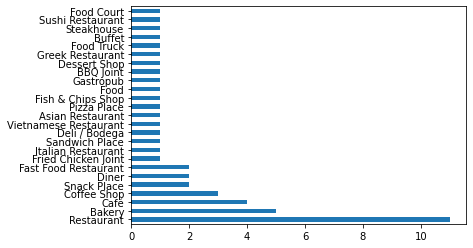

In [180]:
category_graph = restaurants_lelystad['category'].value_counts().plot(kind='barh')
plt.show()

Most of the restaurants are classified by Foursquare as a generic restaurant, which does not give us a lot of information on the types of restaurant that are located in each borough.

## Clustering our data into boroughs
In order for this data to be useful to our research, we will need some information about the types of restaurants located in each borough. To do so, we will cluster a restaurant to the closest borough, based on distance. We do this by implementing an iteration over all restaurants, iterating over all boroughs, using the Haversine formula. 

In [181]:
def haversine(A, B):
    """
    Calculates the distance between two points (A and B).
    
    Params:
        A (tuple): Coordinates in the form (float: lat, float: lng).
        B (tuple): Coordinates in the form (float: lat, float: lng).
        
    Returns:
        float: The distance between points A and B in meters.
    """
    A_lat, A_lng = A
    B_lat, B_lng = B
    distance_lat = B_lat - A_lat
    distance_lng = B_lng - A_lng
    a = sin(distance_lat/2)**2 + cos(A_lat) * cos(B_lat) * sin(distance_lng/2)**2
    c = 2 * asin(sqrt(a))
    return c * 6371000

In [182]:
# Calculate the closest borough
for index, restaurant in restaurants_lelystad.iterrows():
    selected_borough = None
    restaurant_coords = (restaurant['lat'], restaurant['lng'])
    for n, borough in lelystad_boroughs.iterrows():
        borough_coords = (borough['lat'], borough['lng'])
        distance = haversine(restaurant_coords, borough_coords)
        if selected_borough is None or selected_borough[1] > distance:
            selected_borough = (n, distance)
    
    restaurants_lelystad.loc[index, 'borough'] = selected_borough[0]

restaurants_lelystad

,name,category,lat,lng,borough
0,KFC,Fried Chicken Joint,52.482914,5.505881,9
1,McDonald's,Fast Food Restaurant,52.482354,5.505328,9
2,Aan Ut Water,Restaurant,52.551815,5.460253,5
3,PARAPARA Sushi & Grill Cafe,Sushi Restaurant,52.510146,5.476211,7
4,Restaurant Applaus,Restaurant,52.510884,5.475991,7
5,De Rede van Bataviahaven,Restaurant,52.519105,5.438982,16
6,Steak van de Keizer,Steakhouse,52.510215,5.476957,7
7,Le Passage,Café,52.509701,5.475661,7
8,Any Tyme - Snack & Dine,Diner,52.491499,5.483160,9
9,Gino Italiaanse Restaurant,Restaurant,52.502090,5.489030,8


## Visualizing clustered restaurants

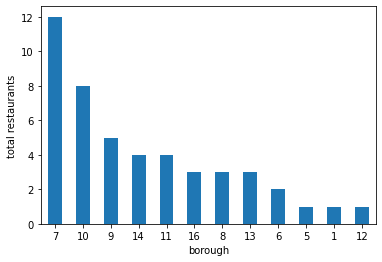

In [183]:
borough_graph = restaurants_lelystad['borough'].value_counts().plot.bar(rot=0, xlabel='borough', ylabel='total restaurants')
plt.show()

As we can see, not all boroughs actually have restaurants clustered to them. Let's see which boroughs that are:

In [184]:
boroughs_with_restaurants = restaurants_lelystad['borough'].unique()
all_boroughs = np.array(lelystad_boroughs.index.tolist())
empty_boroughs = np.setdiff1d(all_boroughs, boroughs_with_restaurants)

boroughs_with_restaurants_dataframe = lelystad_boroughs.loc[set(lelystad_boroughs.index) - set(empty_boroughs)]
boroughs_with_restaurants_dataframe['total'] = restaurants_lelystad['borough'].value_counts()
boroughs_with_restaurants_dataframe['total'].replace(np.nan, 0, inplace=True)
boroughs_with_restaurants_dataframe['total'] = boroughs_with_restaurants_dataframe['total'].astype(int)

empty_borough_dataframe = lelystad_boroughs.loc[set(lelystad_boroughs.index) - set(boroughs_with_restaurants_dataframe.index)]

### Boroughs with restaurants

In [185]:
boroughs_with_restaurants_dataframe

,postal_code,borough,lat,lng,total
1,8212,"Wijngaard, Bongerd, Oostrandpark, Buitenplaats",52.514697,5.492923,1
5,8222,"Biologisch Centrum; Groene Velden, Hazeleger, ...",52.538687,5.483483,1
6,8223,Gildenhof,52.523348,5.481777,2
7,8224,"Lelycentre, Damrif, Kustrif",52.512792,5.477765,12
8,8225,"Archipel, Wold, Horst, Kamp, Griend, Zoom",52.502910,5.486276,3
9,8226,"Sont, Larserdreef",52.490578,5.487027,5
10,8231,"De Stelling, De Schans, De Veste, Schouw, Kemp...",52.531211,5.455288,8
11,8232,"De Gordiaan, Botter-oost, Tjalk",52.506531,5.459658,4
12,8233,"De Doelen, Grietenij",52.496289,5.467008,1
13,8239,"Lelystad-Zuid, bedrijventerrein Flevopoort I e...",52.469773,5.422923,3


### Boroughs without restaurants

In [186]:
empty_borough_dataframe

,postal_code,borough,lat,lng
0,8211,industrieterrein Oostervaart,52.538798,5.501941
2,8218,bedrijvenpark Larserpoort + ten zuiden van Lar...,52.440146,5.353604
3,8219,"Edelhertweg, Runderweg, Dronterweg, Swifterrin...",52.515177,5.481707
4,8221,"IJsselmeerdijk, Karperweg",52.569803,5.478124
15,8242,"Boeier, Puner, Galjoen, Kogge, Gondel, Houtrib...",52.592990,5.234752
17,8244,Lelystad-Haven,52.495409,5.404976
18,8245,"Buizerdweg, Uilenweg",52.488722,5.423648


## Finding correlation
Now we're at a stage that we can discover if there is any possible correlation between the socioeconomic data and the amount of restaurants that we find in a borough. I will not only find the values, but also graph them.

In [187]:
correlation_dataframe = lelystad_socioeconomic.copy()
correlation_dataframe['restaurants'] = restaurants_lelystad['borough'].value_counts()
correlation_dataframe['restaurants'].replace(np.nan, 0, inplace=True)
correlation_dataframe['restaurants'] = correlation_dataframe['restaurants'].astype(int)
correlation_dataframe = correlation_dataframe.drop('postal_code', axis=1)
correlation_dataframe

,INWONER,MAN,VROUW,INW_014,INW_1524,INW_2544,INW_4564,INW_65PL,P_NL_ACHTG,P_WE_MIG_A,...,WON_MRGEZ,P_KOOPWON,P_HUURWON,WON_HCORP,WON_NBEW,WOZWONING,UITKMINAOW,OAD,STED,restaurants
0,285.0,145.0,140.0,35.0,40.0,45.0,95.0,70.0,80.0,10.0,...,30.0,80.0,20.0,NaN,20.0,385.0,10.0,124,5,0
1,4550.0,2270.0,2280.0,715.0,465.0,990.0,1225.0,1150.0,80.0,10.0,...,90.0,90.0,10.0,150.0,45.0,222.0,280.0,956,4,1
2,225.0,125.0,95.0,55.0,35.0,50.0,65.0,20.0,90.0,0.0,...,NaN,70.0,30.0,NaN,5.0,NaN,5.0,18,5,0
3,2925.0,1510.0,1410.0,615.0,450.0,645.0,955.0,255.0,80.0,10.0,...,10.0,90.0,10.0,NaN,30.0,391.0,110.0,292,5,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,NaN,NaN,40,5,0
5,185.0,90.0,90.0,20.0,15.0,15.0,65.0,70.0,80.0,10.0,...,NaN,100.0,NaN,NaN,NaN,581.0,10.0,336,5,1
6,4940.0,2550.0,2390.0,995.0,675.0,1335.0,1255.0,675.0,50.0,10.0,...,665.0,50.0,50.0,850.0,80.0,151.0,730.0,1189,3,2
7,7135.0,3535.0,3595.0,1265.0,805.0,1795.0,1705.0,1570.0,50.0,10.0,...,930.0,50.0,50.0,1265.0,70.0,165.0,875.0,1973,2,12
8,8100.0,4110.0,3990.0,1390.0,965.0,2360.0,2085.0,1300.0,60.0,10.0,...,475.0,60.0,40.0,1245.0,65.0,170.0,950.0,1993,2,3
9,9630.0,4850.0,4780.0,1940.0,1315.0,2535.0,2740.0,1100.0,60.0,10.0,...,585.0,60.0,40.0,1335.0,80.0,205.0,1050.0,1486,3,5


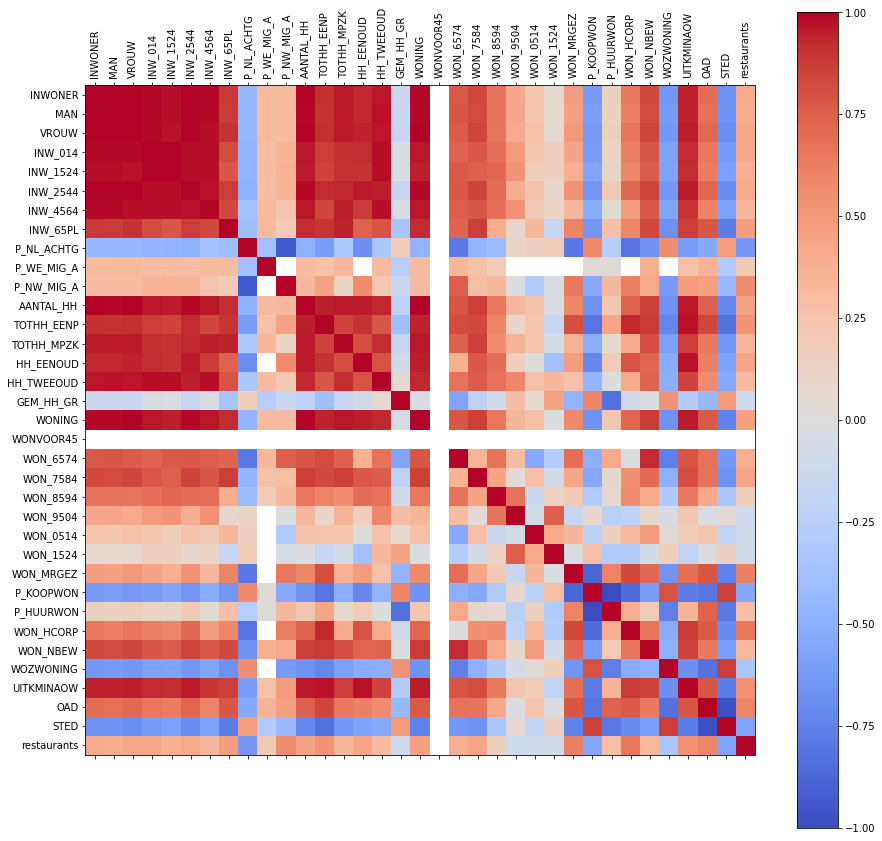

In [188]:
correlation = correlation_dataframe.corr()

# Visualization by https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(111)
cax = ax.matshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
figure.colorbar(cax)
ticks = np.arange(0, len(correlation_dataframe.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(correlation_dataframe.columns)
ax.set_yticklabels(correlation_dataframe.columns)
plt.show()

### Correlation in words
For our research, only the final column (or row) is of good use. We now learn some interesting facts about the correlation between the socioeconomic factors and the amount of restaurants in a borough. For the sake of our research, let's look at the most striking correlations:
- There is a strong negative correlation between P_NL_ACHTG (The percentage of people in a borough with two parents who were born in The Netherlands) and the amount of restaurants in a borough.
- There is a negative correlation between P_KOOPWON (The percentage of bought houses in a borough) and the amount of restaurants in a borough. Vice-versa, there is an equally strong correlation between P_HUURWON (The percentage of rented houses in a borough) and the amount of restaurants in a borough.
- There is a negative correlation between STED (The density of addresses in a borough) and the amount of restaurants in a borough.

## Finding opportunities
Now we know about the correlations in Lelystad between socioeconomic factors and the amount of restaurants in a borough, can we find a borough without restaurants that would fit the correlation? Let's have a look at the boroughs without restaurants again:

In [189]:
empty_borough_dataframe
opportunity_dataframe = lelystad_socioeconomic.loc[set(lelystad_socioeconomic.index) - set(boroughs_with_restaurants_dataframe.index)]
opportunity_dataframe[['P_NL_ACHTG', 'P_KOOPWON', 'P_HUURWON', 'STED']]

,P_NL_ACHTG,P_KOOPWON,P_HUURWON,STED
0,80.0,80.0,20.0,5
2,90.0,70.0,30.0,5
3,80.0,90.0,10.0,5
4,NaN,NaN,NaN,5
15,80.0,70.0,30.0,3
17,80.0,80.0,20.0,4
18,80.0,90.0,10.0,4


Without further analysis, we can already see how the correlation data lines up with the data from these boroughs and why there are no restaurants here:
1. The percentage of of people in the borough with two parents who were born in the Netherlands is very high.
2. The percentage of bought houses is very high, and as a result, the percentage of rented houses in these boroughs is very low.
3. The density of addresses in the borough is very high (the maximum score here is 5).

I would recommend that, all other factors being equal, you should not start a business in any of these boroughs since the correlation shows there is not much opportunity here.

## Conclusion
The results I have found with this study of correlation between socioeconomic factors and the amount of restaurants in a borough is surprising to me. In this research I have shown the following correlations with the amount of restaurants in a borough:
- A positive correlation with the number of houses built between 1945 and 1964.
- A negative correlation with the percentage of people that have two parents who were born in The Netherlands.
- A negative correlation with the number of bought houses in a borough.
- Inversely, a positive correlation with the number of rented houses in a borough.
- A negative correlation with the density of addresses in a borough on a scale of 1 to 5.

I would say more study is needed to find why a restaurant is successful in a certain borough and why these factors are correlated in Lelystad. It might also be interesting to see if these correlations hold in other rapidly developing cities in The Netherlands (like Purmerend and Zoetermeer), if these correlations hold in other cities in Flevoland (most importantly: Almere) and if these correlations hold in the big cities in The Netherlands (For example Amsterdam, Rotterdam, Utrecht).